In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 7-2 (Query Translation - Decomposition (Parallel))"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 7-2: Decomposition (Parallel)

![](images/07-02-decomposition-parallel.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BKNNkmwnKPIhyQizDwbLdbORrY5M5', 'finish_reason': 'stop', 'logprobs': None}, id='run-76f51b10-5761-4578-9db2-91be0e18a334-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

In [14]:
retriever = vectorstore.as_retriever()

## RAG

In [15]:
import operator
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [16]:
decomposition_prompt_template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}"""
print(decomposition_prompt_template)

You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}


In [17]:
sub_question_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(sub_question_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [18]:
rag_prompt_template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""
print(rag_prompt_template)

Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}



In [19]:
def format_qa_pair(question: str, answer: str) -> str:
    return f"Question: {question}  \nAnswer: {answer}\n\n\n"

In [20]:
query = "What are the main components of an LLM-powered autonomous agent system?"

In [21]:
class State(TypedDict):
    question: str
    generated_sub_questions: list[str]
    qa_pairs: Annotated[
        list[dict[str, str]], operator.add
    ]
    context: list[Document]
    answer: str

class RetrieverState(TypedDict):
    generated_sub_question: str

In [22]:
def generate_sub_questions(query: str, config: RunnableConfig) -> list[str]:
    max_generated_sub_questions_count = config['configurable'].get("max_generated_sub_questions_count", 3)
    
    class SubQuestionsGenerator(BaseModel):
        sub_questions: list[str] = Field(
            ..., 
            description="List of generated sub-problems / sub-questions",
            max_items=max_generated_sub_questions_count
        )
    
    structured_llm = llm.with_structured_output(SubQuestionsGenerator, method="function_calling")
    decomposition_prompt = decomposition_prompt_template.format(
        question=query
    )
    response = structured_llm.invoke([
        HumanMessage(content=decomposition_prompt)
    ])
    questions = response.sub_questions
    
    return {"generated_sub_questions": questions}


def assign_sub_questions(state: State):
    return [Send("answer_sub_question", {"generated_sub_question": sub_question}) for sub_question in state["generated_sub_questions"]]


def answer_sub_question(state: RetrieverState):
    question = state["generated_sub_question"]
    context = retriever.invoke(question)
    sub_question_prompt = sub_question_prompt_template.format(
        context=context,
        question=question
    )
    answer = llm.invoke([
        HumanMessage(content=sub_question_prompt)
    ])
    return {"qa_pairs": [{question: answer.content}]}


def aggregate_qa_pairs(state: State):
    context = ""

    for qa_pair in state['qa_pairs']:
        [(question, answer)] = qa_pair.items()
        context += format_qa_pair(question, answer)
    
    return {"context": context}


def generate_answer(state: State):
    rag_prompt = rag_prompt_template.format(
        context=state["context"],
        question=state["question"]
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

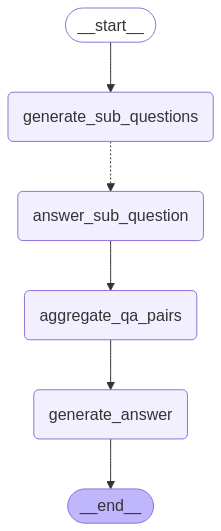

In [23]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_sub_questions", generate_sub_questions)
graph_builder.add_node("answer_sub_question", answer_sub_question)
graph_builder.add_node("aggregate_qa_pairs", aggregate_qa_pairs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_sub_questions")
graph_builder.add_conditional_edges(
    "generate_sub_questions", assign_sub_questions, ["answer_sub_question"]
)
graph_builder.add_edge("answer_sub_question", "aggregate_qa_pairs")
graph_builder.add_edge("aggregate_qa_pairs", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()
graph

In [24]:
print(query)

response = graph.invoke({"question": query})

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What are the main components of an LLM-powered autonomous agent system?


{
    'question': 'What are the main components of an LLM-powered autonomous agent system?',
    'generated_sub_questions': [
        'What is a large language model (LLM) and how does it function?',
        'What role does natural language processing (NLP) play in an LLM-powered system?',
        'What are the key hardware and software components required to build an autonomous agent system using LLM?'
    ],
    'qa_pairs': [{...}, {...}, {...}],
    'context': 'Question: What is a large language model (LLM) and how does it function?  \nAnswer: A large 
language model (LLM) is an advanced AI system designed to understand and generate human-like text. It serves as a 
powerful general problem solver, capable of performing a wide range of tasks beyond writing, such as coding and 
various forms of communication. \n\nIn the context of LLM-powered autonomous agents, the LLM functions as the 
"brain" of the system, interacting with several key components:\n\n1. **Planning**: The LLM helps break down large 
tasks into smaller, manageable subgoals, facilitating the efficient handling of complex tasks.\n\n2. **Reflection 
and Refinement**: The LLM can engage in self-criticism and reflection over past actions, allowing it to learn from 
mistakes and refine its approaches to improve future outputs.\n\n3. **Response Generation**: After executing tasks,
the LLM summarizes results and communicates them to users, acting as a bridge between the operational processes and
the user interface.\n\nHowever, LLMs also face challenges, such as the need for efficiency improvements, managing 
lengthy context windows for complex tasks, and ensuring the stability of outputs. Their reliability as a natural 
language interface can be questioned due to potential formatting errors and unpredictable behavior.\n\n\nQuestion: 
What role does natural language processing (NLP) play in an LLM-powered system?  \nAnswer: Natural language 
processing (NLP) plays a crucial role in an LLM-powered system by serving as the interface between large language 
models (LLMs) and external components, such as memory and tools. It enables the system to understand and process 
human language, allowing for effective communication and interaction. However, the reliability of NLP outputs can 
be questionable, as LLMs may produce formatting errors and occasionally refuse to follow instructions. 
Consequently, much of the agent demo code focuses on parsing the outputs generated by the model to ensure coherent 
and relevant responses. Overall, NLP facilitates the functioning of LLMs in problem-solving and task execution 
within autonomous agents.\n\n\nQuestion: What are the key hardware and software components required to build an 
autonomous agent system using LLM?  \nAnswer: The context provided does not specifically enumerate the key hardware
components required to build an autonomous agent system using LLM. However, it highlights several software 
components crucial for the system\'s functionality:\n\n1. **LLM (Large Language Model)**: Serves as the core 
controller or "brain" of the autonomous agent.\n\n2. **Planning Component**: Enables the agent to break down 
complicated tasks into smaller, manageable subgoals.\n\n3. **Task Decomposition**: Utilizes techniques like Chain 
of Thought (CoT) to enhance performance on complex tasks by guiding the model to think step by step.\n\n4. 
**Reflection and Refinement**: Allows the agent to critique its past actions, learn from mistakes, and improve 
future performance.\n\n5. **Natural Language Interface**: This connects the LLM with external components, such as 
memory and tools, although its reliability is noted to be questionable.\n\nIn summary, while the specific hardware 
requirements aren\'t outlined, the essential software components for building an LLM-powered autonomous agent 
system include the LLM itself, planning and task decomposition capabilities, reflection mechanisms, and a natural 
language interface.\n\n\n',
    'answer':

An LLM-powered autonomous agent system consists of several key components that enable it to function effectively.  
These components include:                                                                                          

 1 Large Language Model (LLM): The core "brain" of the system, responsible for understanding and generating        
   human-like text. It serves as the primary controller for the agent.                                             
 2 Planning Component: This facilitates the breakdown of complex tasks into smaller, manageable subgoals, enabling 
   efficient task handling.                                                                                        
 3 Task Decomposition: Techniques such as Chain of Thought (CoT) are employed to improve performance on intricate  
   tasks by guiding the model to think step by step.                                                               
 4 Reflection and Refinement Mechanism: This allows the agent to critique its past actions, learn from mistakes,   
   and enhance its future performance through iterative self-improvement.                                          
 5 Natural Language Interface: Serving as the connection between the LLM and external components (such as memory   
   and tools), this interface enables effective communication. Although vital, its reliability can be problematic, 
   leading to occasional formatting errors and instruction refusals.                                               

These components work in tandem to allow the LLM-powered autonomous agent to perform a variety of tasks, making it 
a sophisticated problem-solving tool.

In [25]:
print(query)

config = {
    "configurable": {
        "max_generated_sub_questions_count": 5
    }
}
response = graph.invoke({"question": query}, config=config)

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What are the main components of an LLM-powered autonomous agent system?


{
    'question': 'What are the main components of an LLM-powered autonomous agent system?',
    'generated_sub_questions': [
        'What is an LLM (Large Language Model) and how does it function?',
        'What are the roles of input processing in an LLM-powered autonomous agent system?',
        'How does an LLM integrate with other components in an autonomous agent system?',
        'What are the necessary data sources for training an LLM in an autonomous agent?',
        'What are the challenges faced when implementing LLMs in autonomous systems?'
    ],
    'qa_pairs': [{...}, {...}, {...}, {...}, {...}],
    'context': 'Question: What is an LLM (Large Language Model) and how does it function?  \nAnswer: A Large 
Language Model (LLM) is a type of artificial intelligence model designed to understand and generate human language.
It functions by using vast amounts of text data to learn the patterns, structures, and semantics of language, 
enabling it to perform various language-related tasks such as translation, summarization, question-answering, and 
more. \n\nIn the context of LLM-powered autonomous agents, the LLM serves as the core controller or "brain" of the 
agent. It operates by leveraging several key components, including:\n\n1. **Planning**: The LLM can break down 
complex tasks into smaller, manageable subgoals, which helps in handling and executing these tasks more 
efficiently.\n\n2. **Reflection and Refinement**: The LLM is capable of self-assessment, allowing it to critically 
analyze its past actions, learn from mistakes, and make improvements to enhance the quality of its outputs.\n\n3. 
**Response Generation**: After executing tasks, the LLM can summarize the results and communicate them back to the 
user, providing a coherent output that captures the essential information.\n\nOverall, LLMs are powerful tools for 
general problem-solving, moving beyond simple text generation to acting as intelligent agents capable of performing
tasks autonomously.\n\n\nQuestion: What are the roles of input processing in an LLM-powered autonomous agent 
system?  \nAnswer: The context provided does not explicitly detail the roles of input processing in an LLM-powered 
autonomous agent system. However, we can infer its importance based on the information mentioned:\n\n1. **Natural 
Language Interface**: The LLM-powered agents rely on natural language as the interface between the LLMs and 
external components. This suggests that input processing must involve understanding and interpreting user inputs in
natural language to ensure correct interactions with the agent.\n\n2. **Formatting Parsing**: Given that there are 
reliability issues associated with the natural language interface, much of the agent demo code focuses on parsing 
model output. This indicates that input processing may also involve effectively formatting and structuring inputs 
to avoid errors and misinterpretations by the LLM.\n\n3. **Task Decomposition**: Input processing may be vital for 
task decomposition, where the agent breaks down complex tasks into simpler subgoals. This requires the agent to 
process inputs carefully to identify the essential components that can be tackled step-by-step.\n\nOverall, input 
processing in an LLM-powered autonomous agent system likely facilitates comprehension of user requests, ensures 
accurate communication, and aids in the breakdown of tasks for effective problem-solving.\n\n\nQuestion: How does 
an LLM integrate with other components in an autonomous agent system?  \nAnswer: In an LLM-powered autonomous agent
system, the LLM functions as the agent’s brain and integrates with several key components to enhance its 
functionality. These components include:\n\n1. **Planning**: The LLM aids in planning by breaking down complex 
tasks into smaller, manageable subgoals, which allows for efficient handling of intricate tasks.\n\n2. **Subgoal 
and Decomposition**: The agent utilizes techniques like "Chain of Thought" (CoT), w

An LLM-powered autonomous agent system comprises several key components that work together to enable effective     
operation and task management. The main components include:                                                        

 1 Large Language Model (LLM): The core of the system, the LLM serves as the "brain," responsible for understanding
   human language, generating responses, and executing various language-related tasks. It provides the capacity to 
   process and generate natural language, enabling seamless interaction with users.                                
 2 Planning and Task Decomposition: The LLM facilitates planning by breaking down complex tasks into smaller,      
   manageable subgoals. Techniques like "Chain of Thought" (CoT) are employed to simplify tasks by organizing and  
   addressing them step-by-step, improving task execution.                                                         
 3 Input Processing: This component is crucial for interpreting user queries and interfacing with the LLM          
   effectively. It involves understanding natural language inputs, formatting data appropriately, and decomposing  
   tasks into simpler steps. Reliable input processing ensures accurate communication and enhances overall system  
   performance.                                                                                                    
 4 Reflection and Refinement: The LLM has the ability to engage in self-reflection, allowing it to analyze previous
   actions, learn from mistakes, and refine its approaches for future tasks. This capability helps to improve the  
   quality and reliability of the agent's outputs over time.                                                       
 5 Natural Language Interface: The autonomy of the system relies on a natural language interface that connects the 
   LLM with external components, tools, and memory systems. This interface allows users to interact with the agent 
   naturally, although it may present challenges related to accuracy and the reliability of outputs.               
 6 Integration with External Components: The LLM interacts with various external tools and systems, which may      
   include databases, APIs, or other machine learning models. This integration enhances the agent’s ability to     
   perform diverse tasks and access additional resources.                                                          

Overall, these components collaboratively enable an LLM-powered autonomous agent to function as a sophisticated    
problem-solving entity capable of handling diverse tasks and engaging with users effectively.